In [1]:
from model_trainer import ModelTrainer
from verification_net import VerificationNet
from stacked_mnist import StackedMNIST, DataMode

from autoencoder import AutoEncoder

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Tuple

In [3]:
class AutoEncoderTrainer(ModelTrainer):
    def __init__(
            self, 
            model, 
            loss, 
            optimizer,
            device = torch.device("mps"),
            file_name: str | Path = 'models/ae-basic', 
            force_learn: bool = False
        ) -> None:
        super().__init__(model, loss, optimizer, device, file_name, force_learn)

    def get_output_from_batch(self, batch):
        x, _, _ = batch
        x = x.to(self.device)
        _, output = self.model(x)
        return x, output

In [4]:
device = torch.device("mps")
torch.mps.set_per_process_memory_fraction(0.)

In [5]:
latent_space_size = 64
mode = DataMode.MONO

In [6]:
AE = AutoEncoder(latent_space_size=latent_space_size)
AE.to(device)
loss = nn.MSELoss()
opt = optim.Adam(AE.parameters(), lr=1e-5)

In [7]:
Trainer = AutoEncoderTrainer(
        model=AE, 
        loss=loss, 
        optimizer=opt, 
        file_name='models/ae-basic',
        force_learn=False
    )

In [8]:
batch_size = 20_000

In [9]:
noise_img = nn.Softmax(dim=1)(torch.rand(batch_size, latent_space_size))

noise_pred = AE.decoder(noise_img.to(device))

In [10]:
VerifNet = VerificationNet(file_name='models/verification_model_torch_ok_copy')

In [11]:
noise_labels, beliefs = VerifNet.predict(noise_pred)

In [12]:
cov = VerifNet.check_class_coverage(data=noise_pred, tolerance=.8)
pred, acc = VerifNet.check_predictability(data=noise_pred, tolerance=.8)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 100.00%
Predictability: 90.00%


(<Figure size 640x480 with 16 Axes>,
 array([[<Axes: title={'center': '3.0'}>, <Axes: title={'center': '3.0'}>,
         <Axes: title={'center': '3.0'}>, <Axes: title={'center': '3.0'}>],
        [<Axes: title={'center': '3.0'}>, <Axes: title={'center': '8.0'}>,
         <Axes: title={'center': '3.0'}>, <Axes: title={'center': '3.0'}>],
        [<Axes: title={'center': '3.0'}>, <Axes: title={'center': '3.0'}>,
         <Axes: title={'center': '8.0'}>, <Axes: title={'center': '3.0'}>],
        [<Axes: title={'center': '3.0'}>, <Axes: title={'center': '3.0'}>,
         <Axes: title={'center': '3.0'}>, <Axes: title={'center': '8.0'}>]],
       dtype=object))

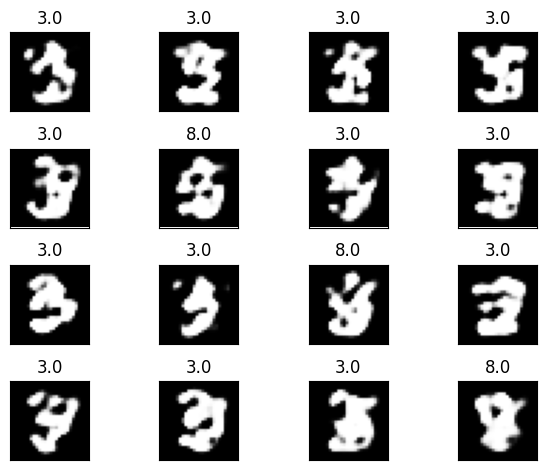

In [13]:
from util import tile_tv_images
arg_beliefs = np.flip(np.argsort(beliefs))[:16]
imgs_gen_to_plot = noise_pred.reshape(-1, 28, 28).to("cpu").detach().numpy()[arg_beliefs]

tile_tv_images(images=imgs_gen_to_plot, labels=noise_labels[arg_beliefs])